<a href="https://colab.research.google.com/github/Kagan777/Kaggle/blob/master/ga-customer-revenue-prediction/kaggle_ga2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/gdrive/My\ Drive/kaggle/ga

/content/gdrive/My Drive/kaggle/ga


In [2]:
ls

all_zero_prediction.csv     final_df.pkl              test_pre_clean.csv
baseline_lgb.csv            final_test_df.pkl         tmp/
clean_test.csv              models/                   train.csv
clean_train.csv             sample_submission_v2.csv
expactation_prediction.csv  test.csv


In [3]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 143.3 MB
GPU RAM Free: 11430MB | Used: 11MB | Util   0% | Total 11441MB


In [4]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import ast
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

pd.options.display.max_columns = 999

In [0]:
# df = pd.read_csv('sample_submission_v2.csv')

## Initial Preprocessing

In [0]:
# del df
# gc.collect()

In [0]:
train_df = pd.read_csv('train.csv', dtype={'fullVisitorId': 'str'}, parse_dates=['date'], low_memory=False)
# train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_df = pd.read_csv('test.csv', dtype={'fullVisitorId': 'str'}, low_memory=False)
# test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [0]:
print(train_df.shape)
print(test_df.shape)

(1708337, 60)
(401589, 60)


In [0]:
train_df.columns = [x.replace('.', '_') for x in train_df.columns]
test_df.columns = [x.replace('.', '_') for x in test_df.columns]

In [0]:
display(train_df.head())
display(test_df.head())

,appInfo_exitScreenName,appInfo_landingScreenName,channelGrouping,contentGroup_contentGroup2,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,eCommerceAction_action_type,eventInfo_eventAction,eventInfo_eventCategory,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,hitNumber,isEntrance,isExit,page_hostname,page_pageTitle,productPrice,promoName,promoPosition,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,referer,social_hasSocialSourceReferral,social_socialNetwork,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,transaction_affiliation,transaction_currencyCode,type,v2ProductCategory,v2ProductName,visitId,visitNumber,visitStartTime
0,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,Organic Search,Bags,2017-10-16,Firefox,desktop,False,Windows,0.0,NaN,NaN,3162355547410993243,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1.0,True,True,shop.googlemerchandisestore.com,Water Bottles & Tumblers | Drinkware | Google ...,"['23990000', '24990000', '4990000', '2990000']",[],[],NaN,NaN,https://www.google.co.uk/search?q=water+bottle...,No,(not set),1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google,NaN,USD,PAGE,"['Home/Drinkware/Water Bottles and Tumblers/',...","['Google 17oz Stainless Steel Sport Bottle', '...",1508198450,1,1508198450
1,shop.googlemerchandisestore.com/asearch.html,shop.googlemerchandisestore.com/home,Referral,(not set),2017-10-16,Chrome,desktop,False,Chrome OS,0.0,NaN,NaN,8934116514970143966,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1.0,True,NaN,shop.googlemerchandisestore.com,Home,[],"['Apparel', 'Backpacks', 'Mens T-Shirts', 'Wom...","['Row 1', 'Row 2 Combo', 'Row 3-1', 'Row 3-2',...",NaN,True,https://sites.google.com/a/google.com/transpor...,No,(not set),NaN,2.0,NaN,2.0,2.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,NaN,NaN,PAGE,[],[],1508176307,6,1508176307
2,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,Direct,(not set),2017-10-16,Chrome,mobile,True,Android,0.0,NaN,NaN,7992466427990357681,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,1.0,True,NaN,shop.googlemerchandisestore.com,Home,[],"['Apparel', 'Backpacks', 'Mens T-Shirts', 'Wom...","['Row 1', 'Row 2 Combo', 'Row 3-1', 'Row 3-2',...",NaN,True,https://www.googlemerchandisestore.com/,No,(not set),NaN,2.0,1.0,2.0,1.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),NaN,NaN,PAGE,[],[],1508201613,1,1508201613
3,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,Organic Search,(not set),2017-10-16,Chrome,desktop,False,Windows,0.0,NaN,NaN,9075655783635761930,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,1.0,True,NaN,shop.googlemerchandisestore.com,Home,[],"['Apparel', 'Backpacks', 'Mens T-Shirts', 'Wom...","['Row 1', 'Row 2 Combo', 'Row 3-1', 'Row 3-2',...",NaN,True,https://www.google.com.tr/,No,(not set),NaN,2.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,

,appInfo_exitScreenName,appInfo_landingScreenName,channelGrouping,contentGroup_contentGroup2,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,eCommerceAction_action_type,eventInfo_eventAction,eventInfo_eventCategory,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,hitNumber,isEntrance,isExit,page_hostname,page_pageTitle,productPrice,promoName,promoPosition,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,referer,social_hasSocialSourceReferral,social_socialNetwork,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,transaction_affiliation,transaction_currencyCode,type,v2ProductCategory,v2ProductName,visitId,visitNumber,visitStartTime
0,shop.googlemerchandisestore.com/home,shop.googlemerchandisestore.com/home,Organic Search,(not set),2018-05-11,Chrome,mobile,True,Android,0.0,Promotion Click,Enhanced Ecommerce,7460955084541987166,(not set),Asia,India,(not set),unknown.unknown,Delhi,Southern Asia,1.0,NaN,NaN,shop.googlemerchandisestore.com,Home,[],['Accessories'],['Category Row 2'],True,NaN,NaN,No,(not set),NaN,4.0,NaN,3.0,1.0,973.0,NaN,NaN,NaN,(not set),NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google,NaN,NaN,EVENT,[],[],1.526099e+09,2.0,1.526099e+09
1,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,Direct,(not set),2018-05-11,Chrome,desktop,False,Macintosh,0.0,NaN,NaN,460252456180441002,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1.0,True,NaN,shop.googlemerchandisestore.com,Home,[],"['Apparel', 'Backpacks', 'Mens T-Shirts', 'Wom...","['Row 1', 'Row 2 Combo', 'Row 3-1', 'Row 3-2',...",NaN,True,NaN,No,(not set),NaN,4.0,NaN,3.0,1.0,49.0,NaN,NaN,NaN,(not set),NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct),NaN,NaN,PAGE,[],[],1.526064e+09,166.0,1.526064e+09
2,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,Organic Search,Apparel,2018-05-11,Chrome,desktop,False,Chrome OS,3.0,Add to Cart,Enhanced Ecommerce,3461808543879602873,not available in demo dataset,Americas,United States,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,Northern America,1.0,NaN,NaN,shop.googlemerchandisestore.com,Women's T-Shirts | Apparel | Google Merchandis...,['21990000'],[],[],NaN,NaN,https://www.google.com/,No,(not set),NaN,4.0,NaN,3.0,1.0,24.0,NaN,NaN,NaN,(not set),NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google,NaN,USD,EVENT,"[""Home/Apparel/Women's/Women's-T-Shirts/""]",['Google Tee White'],1.526067e+09,2.0,1.526067e+09
3,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,Direct,(not set),2018-05-11,Chrome,mobile,True,iOS,0.0,NaN,NaN,975129477712150630,Houston,Americas,United States,Houston TX,(not set),Texas,Northern America,1.0,True,NaN,shop.googlemerchandisestore.com,Home,[],"['Apparel', 'Backpacks', 'Mens T-Shirts', 'Wom...","['Row 1', 'Row 2 Combo', 'Row 3-1', 'Row 3-2',...",NaN,True,https://www.googlemerchandisestore.com/,No,(not set),NaN,5.0,NaN,4.0,1.0,25.0,NaN,NaN,NaN,(not set),NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct),NaN,NaN,PAGE,[],[],1.526108e+09,4.0,1.526108e+09
4,shop.googlemerchandisestore.com/asearch.html,shop.googlemerchandisestore.com/home,Organic Search,(not set),2018-05-11,Internet Explorer,tablet,True,Windows,0.0,NaN,NaN,8381672768065729990,Irvine,Americas,United States,Los Angeles

In [0]:
columns_to_ignore_for_now = ['appInfo_exitScreenName', 'appInfo_landingScreenName', 'geoNetwork_networkDomain', 'geoNetwork_region', 'page_pageTitle', 'promoName', 'promoPosition', 
                             'totals_totalTransactionRevenue', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo_isVideoAd', 'trafficSource_keyword', 'trafficSource_referralPath', 
                             'transaction_affiliation', 'type', 'visitId', 'visitStartTime']

In [0]:
train_df.contentGroup_contentGroup2 = train_df.contentGroup_contentGroup2.fillna('NA').replace('(not set)', 'NA')
test_df.contentGroup_contentGroup2 = test_df.contentGroup_contentGroup2.fillna('NA').replace('(not set)', 'NA')

In [0]:
tmp = train_df.device_browser.value_counts(dropna=False) > 100
device_browser_to_keep = (tmp[tmp].index)
train_df.loc[~train_df.device_browser.isin(device_browser_to_keep), 'device_browser'] = 'Other'
test_df.loc[~test_df.device_browser.isin(device_browser_to_keep), 'device_browser'] = 'Other'

In [0]:
tmp = train_df.device_operatingSystem.value_counts(dropna=False) > 20000
os_browser_to_keep = (tmp[tmp].index)
train_df.loc[~train_df.device_operatingSystem.isin(os_browser_to_keep), 'device_operatingSystem'] = 'Other'
test_df.loc[~test_df.device_operatingSystem.isin(os_browser_to_keep), 'device_operatingSystem'] = 'Other'

In [0]:
train_df[['eventInfo_eventAction', 'eventInfo_eventCategory', 'page_hostname', 'trafficSource_adwordsClickInfo_slot']] = train_df[['eventInfo_eventAction', 'eventInfo_eventCategory', 'page_hostname', 'trafficSource_adwordsClickInfo_slot']].fillna('NA')
test_df[['eventInfo_eventAction', 'eventInfo_eventCategory', 'page_hostname', 'trafficSource_adwordsClickInfo_slot']] = test_df[['eventInfo_eventAction', 'eventInfo_eventCategory', 'page_hostname', 'trafficSource_adwordsClickInfo_slot']].fillna('NA')

In [0]:
tmp = train_df.geoNetwork_city.value_counts(dropna=False) > 100
city_to_keep = [x for x in list(tmp[tmp].index) if x != '(not set)']
train_df.loc[~train_df.geoNetwork_city.isin(city_to_keep), 'geoNetwork_city'] = 'Other'
test_df.loc[~test_df.geoNetwork_city.isin(city_to_keep), 'geoNetwork_city'] = 'Other'

In [0]:
train_df[['geoNetwork_continent', 'geoNetwork_subContinent']] = train_df[['geoNetwork_continent', 'geoNetwork_subContinent']].replace('(not set)', 'NA')
test_df[['geoNetwork_continent', 'geoNetwork_subContinent']] = test_df[['geoNetwork_continent', 'geoNetwork_subContinent']].replace('(not set)', 'NA')

In [0]:
train_df.geoNetwork_subContinent.replace('(not set)', 'NA', inplace=True)
test_df.geoNetwork_subContinent.replace('(not set)', 'NA', inplace=True)

In [0]:
tmp = train_df.geoNetwork_country.value_counts(dropna=False) > 1000
coutry_to_keep = [x for x in list(tmp[tmp].index) if x != '(not set)']
train_df.loc[~train_df.geoNetwork_country.isin(coutry_to_keep), 'geoNetwork_country'] = 'Other'
test_df.loc[~test_df.geoNetwork_country.isin(coutry_to_keep), 'geoNetwork_country'] = 'Other'

In [0]:
tmp = train_df.geoNetwork_metro.value_counts(dropna=False) > 100
metro_to_keep = [x for x in list(tmp[tmp].index) if x not in ['(not set)', 'not available in demo dataset']]
train_df.loc[~train_df.geoNetwork_metro.isin(metro_to_keep), 'geoNetwork_metro'] = 'Other'
test_df.loc[~test_df.geoNetwork_metro.isin(metro_to_keep), 'geoNetwork_metro'] = 'Other'

In [0]:
train_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews' , 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']] = \
train_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews' , 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']].fillna(0.0)
test_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews' , 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']] = \
test_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews' , 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']].fillna(0.0)

In [0]:
train_df[['isEntrance', 'isExit', 'promotionActionInfo_promoIsClick', 'promotionActionInfo_promoIsView', 'trafficSource_isTrueDirect']] = \
train_df[['isEntrance', 'isExit', 'promotionActionInfo_promoIsClick', 'promotionActionInfo_promoIsView', 'trafficSource_isTrueDirect']].fillna(False)
test_df[['isEntrance', 'isExit', 'promotionActionInfo_promoIsClick', 'promotionActionInfo_promoIsView', 'trafficSource_isTrueDirect']] = \
test_df[['isEntrance', 'isExit', 'promotionActionInfo_promoIsClick', 'promotionActionInfo_promoIsView', 'trafficSource_isTrueDirect']].fillna(False)

In [0]:
train_df.referer.fillna('NA', inplace=True)
test_df.referer.fillna('NA', inplace=True)
tmp = train_df.referer.value_counts(dropna=False) > 1000
to_keep = [x for x in list(tmp[tmp].index) if x != '(not set)']
train_df.loc[~train_df.referer.isin(to_keep), 'referer'] = 'Other'
test_df.loc[~test_df.referer.isin(to_keep), 'referer'] = 'Other'

In [0]:
train_df.social_hasSocialSourceReferral = np.where(train_df.social_hasSocialSourceReferral == 'Yes', 1, 0)
test_df.social_hasSocialSourceReferral = np.where(test_df.social_hasSocialSourceReferral == 'Yes', 1, 0)

In [0]:
tmp = train_df.social_socialNetwork.value_counts(dropna=False) > 100
to_keep = [x for x in list(tmp[tmp].index) if x != '(not set)']
train_df.loc[~train_df.social_socialNetwork.isin(to_keep), 'social_socialNetwork'] = 'Other'
test_df.loc[~test_df.social_socialNetwork.isin(to_keep), 'social_socialNetwork'] = 'Other'

In [0]:
train_df.loc[~train_df.trafficSource_adwordsClickInfo_adNetworkType.isin(['Content', 'Google Search']), 'trafficSource_adwordsClickInfo_adNetworkType'] = 'NA'
test_df.loc[~test_df.trafficSource_adwordsClickInfo_adNetworkType.isin(['Content', 'Google Search']), 'trafficSource_adwordsClickInfo_adNetworkType'] = 'NA'

In [0]:
train_df.trafficSource_campaign = np.where(train_df.trafficSource_campaign == '(not set)', 0, 1)
test_df.trafficSource_campaign = np.where(test_df.trafficSource_campaign == '(not set)', 0, 1)

In [0]:
train_df.trafficSource_medium = train_df.trafficSource_medium.fillna('NA').replace(['(none)', '(not set)'], 'NA')
test_df.trafficSource_medium = test_df.trafficSource_medium.fillna('NA').replace(['(none)', '(not set)'], 'NA')

In [0]:
tmp = train_df.trafficSource_source.value_counts(dropna=False) > 75
to_keep = [x for x in list(tmp[tmp].index) if x != '(not set)']
train_df.loc[~train_df.trafficSource_source.isin(to_keep), 'trafficSource_source'] = 'Other'
test_df.loc[~test_df.trafficSource_source.isin(to_keep), 'trafficSource_source'] = 'Other'

In [0]:
train_df.transaction_currencyCode = np.where(train_df.transaction_currencyCode == 'USD', 1, 0)
test_df.transaction_currencyCode = np.where(test_df.transaction_currencyCode == 'USD', 1, 0)

In [0]:
train_df.columns

Index(['appInfo_exitScreenName', 'appInfo_landingScreenName',
       'channelGrouping', 'contentGroup_contentGroup2', 'date',
       'device_browser', 'device_deviceCategory', 'device_isMobile',
       'device_operatingSystem', 'eCommerceAction_action_type',
       'eventInfo_eventAction', 'eventInfo_eventCategory', 'fullVisitorId',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'hitNumber', 'isEntrance', 'isExit',
       'page_hostname', 'page_pageTitle', 'productPrice', 'promoName',
       'promoPosition', 'promotionActionInfo_promoIsClick',
       'promotionActionInfo_promoIsView', 'referer',
       'social_hasSocialSourceReferral', 'social_socialNetwork',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim', 'totals_timeOnSite',
       'totals_totalTransactionRevenue', 'totals_transactionR

In [0]:
columns_to_use = [x for x in train_df.columns if x not in columns_to_ignore_for_now]

In [0]:
columns_of_lists = ['productPrice', 'v2ProductCategory', 'v2ProductName']

In [0]:
columns_to_encode = ['channelGrouping', 'contentGroup_contentGroup2', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'eventInfo_eventAction', 'eventInfo_eventCategory'
                     'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_subContinent', 'page_hostname', 'referer', 'social_socialNetwork', 
                     'trafficSource_adwordsClickInfo_adNetworkType', 'trafficSource_adwordsClickInfo_slot', 'trafficSource_medium', 'trafficSource_source']

In [0]:
train_df[columns_to_use].nunique(dropna=False)

channelGrouping                                       8
contentGroup_contentGroup2                           10
date                                                638
device_browser                                       22
device_deviceCategory                                 3
device_isMobile                                       2
device_operatingSystem                                7
eCommerceAction_action_type                           7
eventInfo_eventAction                                 7
eventInfo_eventCategory                               3
fullVisitorId                                   1323730
geoNetwork_city                                     292
geoNetwork_continent                                  6
geoNetwork_country                                   81
geoNetwork_metro                                     63
geoNetwork_subContinent                              23
hitNumber                                            86
isEntrance                                      

In [0]:
train_df[columns_to_use].shape

(1708337, 44)

In [0]:
train_df[columns_to_use].head()

,channelGrouping,contentGroup_contentGroup2,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,eCommerceAction_action_type,eventInfo_eventAction,eventInfo_eventCategory,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_subContinent,hitNumber,isEntrance,isExit,page_hostname,productPrice,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,referer,social_hasSocialSourceReferral,social_socialNetwork,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_medium,trafficSource_source,transaction_currencyCode,v2ProductCategory,v2ProductName,visitNumber
0,Organic Search,Bags,2017-10-16,Firefox,desktop,False,Windows,0.0,NA,NA,3162355547410993243,not available in demo dataset,Europe,Germany,Other,Western Europe,1.0,True,True,shop.googlemerchandisestore.com,"['23990000', '24990000', '4990000', '2990000']",False,False,Other,0,Other,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NA,NA,0,False,organic,google,1,"['Home/Drinkware/Water Bottles and Tumblers/',...","['Google 17oz Stainless Steel Sport Bottle', '...",1
1,Referral,NA,2017-10-16,Chrome,desktop,False,Chrome OS,0.0,NA,NA,8934116514970143966,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,Northern America,1.0,True,False,shop.googlemerchandisestore.com,[],False,True,Other,0,Other,0.0,2.0,0.0,2.0,2.0,28.0,0.0,0.0,NA,NA,0,False,referral,sites.google.com,0,[],[],6
2,Direct,NA,2017-10-16,Chrome,mobile,True,Android,0.0,NA,NA,7992466427990357681,not available in demo dataset,Americas,United States,Other,Northern America,1.0,True,False,shop.googlemerchandisestore.com,[],False,True,https://www.googlemerchandisestore.com/,0,Other,0.0,2.0,1.0,2.0,1.0,38.0,0.0,0.0,NA,NA,0,True,NA,(direct),0,[],[],1
3,Organic Search,NA,2017-10-16,Chrome,desktop,False,Windows,0.0,NA,NA,9075655783635761930,not available in demo dataset,Asia,Turkey,Other,Western Asia,1.0,True,False,shop.googlemerchandisestore.com,[],False,True,https://www.google.com.tr/,0,Other,0.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,NA,NA,0,False,organic,google,0,[],[],1
4,Organic Search,NA,2017-10-16,Chrome,desktop,False,Windows,0.0,NA,NA,6960673291025684308,not available in demo dataset,Americas,Mexico,Other,Central America,1.0,True,False,shop.googlemerchandisestore.com,[],False,True,https://www.google.com.mx/,0,Other,0.0,2.0,1.0,2.0,1.0,52.0,0.0,0.0,NA,NA,0,False,organic,google,0,[],[],1


In [0]:
test_df.type.value_counts(dropna=False)

PAGE     399509
EVENT      2021
NaN          59
Name: type, dtype: int64

In [0]:
train_df[columns_to_use].to_csv('clean_train.csv', index=False)
test_df[columns_to_use].to_csv('clean_test.csv', index=False)

## Aggregation by VisitorId

In [266]:
train_df = pd.read_csv('clean_train.csv', dtype={'fullVisitorId': 'str'}, parse_dates=['date'], keep_default_na=False, low_memory=False)
test_df = pd.read_csv('clean_test.csv', dtype={'fullVisitorId': 'str'}, parse_dates=['date'], keep_default_na=False, low_memory=False)
print(train_df.shape, test_df.shape)

(1708337, 44) (401589, 44)


In [0]:
test_df.loc[test_df[test_df.totals_hits == ''].index, ['totals_hits', 'visitNumber']] = test_df.loc[test_df[test_df.totals_hits == ''].index, ['totals_hits', 'visitNumber']].replace('', 1)

In [0]:
train_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions', 'visitNumber']] = \
train_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions', 'visitNumber']].astype('int')
test_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']] = \
test_df[['eCommerceAction_action_type', 'hitNumber', 'totals_bounces', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions']].astype('int')
test_df[['totals_hits', 'visitNumber']] = test_df[['totals_hits', 'visitNumber']].astype('float64').astype('int')

In [0]:
df = pd.concat([train_df, test_df])

In [0]:
def str_list_to_int_list(cell):
  try:
    return [int(y.strip()) for y in ast.literal_eval(cell)]
  except:
    return [0]
  
def list_min_max(cell, mode):
  try:
    if mode == 'max':
      return np.max(cell)
    else:
      return np.min(cell)
  except:
    return 0
  
def products_count(cell):
  if len(cell) == 1 and cell[0] == 0:
    return 0
  else:
    return len(cell)

In [0]:
agg_dict = {
    'channelGrouping': 'last',
    'contentGroup_contentGroup2': 'last',
    'date': 'count',
    'device_browser': 'last',
    'device_deviceCategory': 'last',
    'device_isMobile': 'max',
    'device_operatingSystem': 'last',
    'eCommerceAction_action_type': 'max',
    'eventInfo_eventAction': 'last',
    'eventInfo_eventCategory': 'last',
    'geoNetwork_city': 'last',
    'geoNetwork_continent': 'last',
    'geoNetwork_country': 'last',
    'geoNetwork_metro': 'last',
    'geoNetwork_subContinent': 'last',
    'hitNumber': 'max',
    'isEntrance': 'min',
    'isExit': 'max',
    'page_hostname': 'last',
    'promotionActionInfo_promoIsClick': 'max',
    'promotionActionInfo_promoIsView': 'max',
    'referer': 'last',
    'social_hasSocialSourceReferral': 'max',
    'social_socialNetwork': 'last',
    'totals_bounces': 'sum',
    'totals_hits': 'sum',
    'totals_newVisits': 'last',
    'totals_pageviews': 'sum',
    'totals_sessionQualityDim': 'max',
    'totals_timeOnSite': 'sum',
    'totals_transactionRevenue': 'sum',
    'totals_transactions': 'sum',
    'trafficSource_adwordsClickInfo_adNetworkType': 'last',
    'trafficSource_adwordsClickInfo_slot': 'last',
    'trafficSource_campaign': 'max',
    'trafficSource_isTrueDirect': 'max',
    'trafficSource_medium': 'last',
    'trafficSource_source': 'last',
    'transaction_currencyCode': 'last',
    'visitNumber': 'max',
    'time_from_visit_date': 'min',
    'product_price_sum': 'sum',
    'product_price_count': 'sum',
#     'product_price_mean': ''
    'product_price_min': 'min',
    'product_price_max': 'max'
#     'productPrice': '',
#     'v2ProductCategory': '',
#     'v2ProductName': ''

}

In [0]:
activity_period = [
    (20160801, 20170115),
    (20170115, 20170630),
    (20170701, 20171215),
    (20171216, 20180601),
    # Using the same months!
    (20170501, 20171015),
]

predict_period = [
    (20170301, 20170430),
    (20170815, 20171015),
    (20180201, 20180331),
    (20180715, 20180915),
    # Using the same months!
    (20171201, 20180131),
]

In [273]:
# revenues_list = []
batches = []


for i in range(5):
    print("\nPeriod", i+1)
    a = pd.datetime(int(str(activity_period[i][0])[:4]), int(str(activity_period[i][0])[4:6]), int(str(activity_period[i][0])[6:]))
    b = pd.datetime(int(str(activity_period[i][1])[:4]), int(str(activity_period[i][1])[4:6]), int(str(activity_period[i][1])[6:]))
    batch = df[(df.date >= a) & (df.date <= b)].copy()
    batch.productPrice = batch.productPrice.apply(str_list_to_int_list)
    batch['time_from_visit_date'] = (batch.date.max() - batch.date).dt.days
    batch['product_price_sum'] = batch.productPrice.apply(lambda x: np.sum(x))
    batch['product_price_count'] = batch.productPrice.apply(products_count)
#     batch['product_price_mean'] = batch.productPrice.apply(lambda x: np.mean(x)).fillna(0)
    batch['product_price_min'] = batch.productPrice.apply(list_min_max, mode='min')
    batch['product_price_max'] = batch.productPrice.apply(list_min_max, mode='max')
    batch.sort_values('date', inplace=True)
    batch_gb = batch.groupby('fullVisitorId').agg(agg_dict)
    batch_gb['product_price_mean'] = batch_gb.product_price_sum / batch_gb.product_price_count
    batch_visitors = batch_gb.index
    print("There are", len(batch_visitors), "visitors in 5.5 months")
    
    c = pd.datetime(int(str(predict_period[i][0])[:4]), int(str(predict_period[i][0])[4:6]), int(str(predict_period[i][0])[6:]))
    d = pd.datetime(int(str(predict_period[i][1])[:4]), int(str(predict_period[i][1])[4:6]), int(str(predict_period[i][1])[6:]))
    pred = df[(df.date >= c) & (df.date <= d)]
    pred_visitors = pred.fullVisitorId.unique()
    pred_gb = pred.groupby('fullVisitorId').agg({'totals_transactionRevenue': ['sum', 'count']})
    pred_gb.columns = ['_'.join(col).strip() for col in pred_gb.columns.values]
    print("There are", len(pred_visitors), "visitors in 2 months")
    # Returning visitors
    same_visitors = np.intersect1d(batch_visitors, pred_visitors)
    print("{} visitors returned or {:.2f}%".format(len(same_visitors), 100*len(same_visitors)/len(batch_visitors)))
    # Returning visitors revenue
    with_rev = pred[(pred.fullVisitorId.isin(same_visitors)) & (pred.totals_transactionRevenue > 0)]
    print("And only {} returning visitors have revenue or {:.2f}% from total".format(len(with_rev), 100*len(with_rev)/len(batch_visitors)))
    print("The total revenue for this users is U$$ {:.2f}".format(with_rev.totals_transactionRevenue.sum()/1000000))
    batch_gb = batch_gb.merge(pred_gb, how='left', left_index=True, right_index=True)
    batches.append(batch_gb)
#     revenues_list.append(with_rev.copy(deep=True))


Period 1
There are 377186 visitors in 5.5 months
There are 111299 visitors in 2 months
1871 visitors returned or 0.50%
And only 210 returning visitors have revenue or 0.06% from total
The total revenue for this users is U$$ 102504.27

Period 2
There are 286797 visitors in 5.5 months
There are 147702 visitors in 2 months
2002 visitors returned or 0.70%
And only 146 returning visitors have revenue or 0.05% from total
The total revenue for this users is U$$ 56149.53

Period 3
There are 384946 visitors in 5.5 months
There are 140808 visitors in 2 months
2943 visitors returned or 0.76%
And only 148 returning visitors have revenue or 0.04% from total
The total revenue for this users is U$$ 15886.58

Period 4
There are 366912 visitors in 5.5 months
There are 105385 visitors in 2 months
1962 visitors returned or 0.53%
And only 146 returning visitors have revenue or 0.04% from total
The total revenue for this users is U$$ 46974.64

Period 5
There are 329636 visitors in 5.5 months
There are 144

In [274]:
for i, batch in enumerate(batches):
  batch['batch'] = i + 1
  batch[['totals_transactionRevenue_sum', 'totals_transactionRevenue_count']] = batch[['totals_transactionRevenue_sum', 'totals_transactionRevenue_count']].fillna(0)
  print(batch.totals_transactionRevenue_sum.sum() / 1000000, batch.totals_transactionRevenue_count.sum())

102504.27 4184.0
56149.53 4039.0
15886.58 6710.0
46974.64 4286.0
16821.74 5924.0


In [0]:
final_df = pd.concat(batches)

In [0]:
final_df.rename(columns={'date': 'number_visits_in_period'}, inplace=True)

In [0]:
final_df.product_price_mean.fillna(0, inplace=True)

In [0]:
final_df.to_pickle('final_df.pkl')

In [0]:
test_df.productPrice = test_df.productPrice.apply(str_list_to_int_list)
test_df['time_from_visit_date'] = (test_df.date.max() - test_df.date).dt.days
test_df['product_price_sum'] = test_df.productPrice.apply(lambda x: np.sum(x))
test_df['product_price_count'] = test_df.productPrice.apply(products_count)
test_df['product_price_min'] = test_df.productPrice.apply(list_min_max, mode='min')
test_df['product_price_max'] = test_df.productPrice.apply(list_min_max, mode='max')
test_df.sort_values('date', inplace=True)
final_test_df = test_df.groupby('fullVisitorId').agg(agg_dict)
final_test_df['product_price_mean'] = final_test_df.product_price_sum / final_test_df.product_price_count
final_test_df.product_price_mean.fillna(0, inplace=True)
final_test_df.rename(columns={'date': 'number_visits_in_period'}, inplace=True)
batch_visitors = final_test_df.index
print("There are", len(batch_visitors), "visitors in 5.5 months")

There are 296530 visitors in 5.5 months


In [0]:
final_test_df.to_pickle('final_test_df.pkl')

## Model Training

In [5]:
from fastai.structured import *
from fastai.column_data import *

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [0]:
final_df = pd.read_pickle('final_df.pkl')

In [0]:
final_test_df = pd.read_pickle('final_test_df.pkl')

In [8]:
final_df.shape, final_test_df.shape

((1745477, 49), (296530, 46))

In [9]:
final_df.head()

,channelGrouping,contentGroup_contentGroup2,number_visits_in_period,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,eCommerceAction_action_type,eventInfo_eventAction,eventInfo_eventCategory,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_subContinent,hitNumber,isEntrance,isExit,page_hostname,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,referer,social_hasSocialSourceReferral,social_socialNetwork,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_medium,trafficSource_source,transaction_currencyCode,visitNumber,time_from_visit_date,product_price_sum,product_price_count,product_price_min,product_price_max,product_price_mean,totals_transactionRevenue_sum,totals_transactionRevenue_count,batch
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,Organic Search,NA,1,Chrome,desktop,False,Macintosh,0,NA,NA,not available in demo dataset,Oceania,New Zealand,Other,Australasia,1,True,False,shop.googlemerchandisestore.com,False,True,https://www.google.co.nz/,0,Other,0,11,1,8,0,194,0,0,NA,NA,0,False,organic,google,0,1,87,0.0,0,0,0,0.0,0.0,0.0,1
0000020424342248747,Organic Search,NA,1,Chrome,desktop,False,Windows,0,NA,NA,La Victoria,Americas,Peru,Other,South America,1,True,False,www.googlemerchandisestore.com,False,False,https://www.google.com.pe/,0,Other,0,17,1,13,0,297,0,0,NA,NA,0,False,NA,(direct),0,1,46,0.0,0,0,0,0.0,0.0,0.0,1
000005103959234087,Organic Search,NA,1,Chrome,mobile,True,Android,0,NA,NA,not available in demo dataset,Americas,United States,Other,Northern America,1,True,False,www.googlemerchandisestore.com,False,False,http://www.google.com/,0,Other,0,10,1,8,0,202,0,0,NA,NA,0,False,organic,google,0,1,147,0.0,0,0,0,0.0,0.0,0.0,1
0000093957001069502,Organic Search,NA,1,Chrome,desktop,False,Windows,0,NA,NA,not available in demo dataset,Americas,United States,Other,Northern America,1,True,False,www.googlemerchandisestore.com,False,False,https://www.google.com/,0,Other,0,2,1,2,0,4,0,0,NA,NA,0,False,NA,(direct),0,1,110,0.0,0,0,0,0.0,0.0,0.0,1
0000114156543135683,Social,NA,1,Safari,desktop,False,Macintosh,0,NA,NA,Istanbul,Asia,Turkey,Other,Western Asia,1,True,True,shop.googlemerchandisestore.com,False,True,https://www.youtube.com/yt/about/,1,YouTube,1,1,1,1,0,0,0,0,NA,NA,0,False,referral,youtube.com,0,1,160,0.0,0,0,0,0.0,0.0,0.0,1


In [10]:
final_test_df.head()

,channelGrouping,contentGroup_contentGroup2,number_visits_in_period,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,eCommerceAction_action_type,eventInfo_eventAction,eventInfo_eventCategory,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_subContinent,hitNumber,isEntrance,isExit,page_hostname,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,referer,social_hasSocialSourceReferral,social_socialNetwork,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_medium,trafficSource_source,transaction_currencyCode,visitNumber,time_from_visit_date,product_price_sum,product_price_count,product_price_min,product_price_max,product_price_mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000018966949534117,Organic Search,Apparel,1,Chrome,desktop,False,Macintosh,0,NA,NA,San Jose,Americas,United States,San Francisco-Oakland-San Jose CA,Northern America,1,True,False,shop.googlemerchandisestore.com,False,False,https://www.google.com/,0,Other,0,7,1,7,1,131,0,0,NA,NA,0,False,organic,google,1,1,63,261880000.0,12,18990000,23990000,2.182333e+07
0000039738481224681,Direct,NA,1,Chrome,mobile,True,Android,0,NA,NA,not available in demo dataset,Americas,United States,Other,Northern America,1,True,True,shop.googlemerchandisestore.com,False,True,NA,0,Other,1,1,1,1,1,0,0,0,NA,NA,0,True,NA,(direct),0,1,124,0.0,0,0,0,0.000000e+00
0000073585230191399,Organic Search,Brands,1,Safari,mobile,True,iOS,0,NA,NA,not available in demo dataset,Americas,United States,Other,Northern America,1,True,True,shop.googlemerchandisestore.com,False,False,https://www.google.com/,0,Other,1,1,1,1,1,0,0,0,NA,NA,0,False,organic,google,1,1,134,223880000.0,12,3990000,26990000,1.865667e+07
0000087588448856385,Organic Search,NA,1,Chrome,desktop,False,Windows,0,NA,NA,not available in demo dataset,Asia,Taiwan,Other,Eastern Asia,1,True,True,www.googlemerchandisestore.com,False,False,https://www.google.com.tw/,0,Other,1,1,1,1,1,0,0,0,NA,NA,0,False,organic,google,0,1,131,0.0,0,0,0,0.000000e+00
0000149787903119437,Organic Search,NA,1,Chrome,mobile,True,Android,0,NA,NA,not available in demo dataset,Europe,Serbia,Other,Southern Europe,1,True,True,www.googlemerchandisestore.com,False,False,http://www.google.com/,0,Other,1,1,1,1,1,0,0,0,NA,NA,0,False,organic,google,0,1,147,0.0,0,0,0,0.000000e+00


In [0]:
activity_period = [
    (20160801, 20170115),
    (20170115, 20170630),
    (20170701, 20171215),
    (20171216, 20180601),
    # Using the same months!
    (20170501, 20171015),
]

predict_period = [
    (20170301, 20170430),
    (20170715, 20170915),
    (20180201, 20180331),
    (20180715, 20180915),
    # Using the same months!
    (20171201, 20180131),
]

In [0]:
cat_features = ['channelGrouping', 'contentGroup_contentGroup2', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'eventInfo_eventAction', 'eventInfo_eventCategory',
                'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_subContinent', 'page_hostname', 'referer', 'social_socialNetwork', 
                'trafficSource_adwordsClickInfo_adNetworkType', 'trafficSource_adwordsClickInfo_slot', 'trafficSource_medium', 'trafficSource_source']
numeric_features = [x for x in final_df.columns if x not in cat_features + ['totals_transactionRevenue_sum', 'totals_transactionRevenue_count', 'batch']]

In [0]:
for v in cat_features: final_df[v] = final_df[v].astype('category').cat.as_ordered()

In [0]:
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

In [0]:
apply_cats(final_test_df, final_df)

In [0]:
for v in numeric_features:
#     print(v)
    final_df[v] = final_df[v].fillna(0).astype('float32')
    final_test_df[v] = final_test_df[v].fillna(0).astype('float32')

In [0]:
final_df['purchase'] = final_df.totals_transactionRevenue_sum > 0

In [0]:
final_df.reset_index(inplace=True)

In [327]:
final_df.shape

(1745477, 51)

In [0]:
# relevant_columns_df = final_df[cat_features + numeric_features + ['purchase']].copy()

In [0]:
# val_idx = final_df[final_df.batch == 5].index

In [0]:
# processed_df, _, nas, mapper = proc_df(relevant_columns_df, 'purchase', do_scale=True)

In [0]:
# y = relevant_columns_df['purchase']

In [0]:
# mapper

In [0]:
# processed_test_df, _, nas, mapper = proc_df(final_test_df[cat_features + numeric_features].copy(), do_scale=True, mapper=mapper, na_dict=nas)

In [0]:
# processed_df.head()

## Fast.ai related

In [0]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [0]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)



In [0]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [0]:
md = ColumnarModelData.from_data_frame('/tmp', val_idx, processed_df, y.astype('int'), cat_flds=cat_features, bs=128, test_df=processed_test_df)

In [0]:
cat_sz = [(c, len(final_df[c].cat.categories)+1) for c in cat_features]
cat_sz

[('channelGrouping', 9),
 ('contentGroup_contentGroup2', 11),
 ('device_browser', 23),
 ('device_deviceCategory', 4),
 ('device_operatingSystem', 8),
 ('eventInfo_eventAction', 8),
 ('eventInfo_eventCategory', 4),
 ('geoNetwork_city', 293),
 ('geoNetwork_continent', 7),
 ('geoNetwork_country', 82),
 ('geoNetwork_metro', 64),
 ('geoNetwork_subContinent', 24),
 ('page_hostname', 4),
 ('referer', 121),
 ('social_socialNetwork', 13),
 ('trafficSource_adwordsClickInfo_adNetworkType', 4),
 ('trafficSource_adwordsClickInfo_slot', 5),
 ('trafficSource_medium', 7),
 ('trafficSource_source', 60)]

In [0]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(9, 5),
 (11, 6),
 (23, 12),
 (4, 2),
 (8, 4),
 (8, 4),
 (4, 2),
 (293, 50),
 (7, 4),
 (82, 41),
 (64, 32),
 (24, 12),
 (4, 2),
 (121, 50),
 (13, 7),
 (4, 2),
 (5, 3),
 (7, 4),
 (60, 30)]

In [0]:
model = MixedInputModel(emb_szs, n_cont=0, emb_drop=0.04, out_sz=2, szs=[1000,500], drops=[0.001,0.01]).cuda()

In [0]:
bm = BasicModel(model, 'binary_classifier')

In [0]:
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy>

<function torch.nn.functional.cross_entropy>

In [0]:
# m.summary

In [0]:
learn.lr_find()

 40%|████      | 4477/11062 [01:26<02:05, 52.54it/s, loss=0.00807]

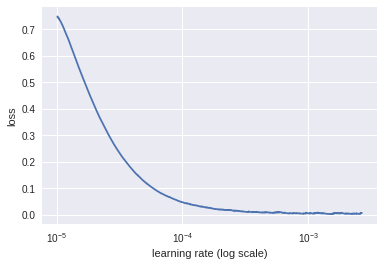

In [0]:
learn.sched.plot()

In [0]:
lr = 1e-4

In [0]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   
    0      0.005914   0.003771  


[array([0.00377])]

In [0]:
preds = np.argmax(learn.predict(), axis=1) 

In [0]:
preds.sum()

0

## LGBM (https://www.kaggle.com/plasticgrammer/customer-revenue-prediction-v2-playground)

In [0]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [0]:
params={'learning_rate': 0.02,
        'objective':'binary',
        'metric':['auc'],
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

In [0]:
x_train = final_df[final_df.batch < 5][cat_features + numeric_features].copy()
x_val = final_df[final_df.batch == 5][cat_features + numeric_features].copy()
y_train = final_df[final_df.batch < 5]['purchase']
y_val = final_df[final_df.batch == 5]['purchase']

In [0]:
reg = lgb.LGBMRegressor(**params, n_estimators=3000)
reg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=500)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	valid_0's auc: 0.941942


LGBMRegressor(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.6, importance_type='split',
       learning_rate=0.02, max_depth=-1, metric='auc',
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=31, objective='binary',
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [0]:
y_pred = reg.predict(x_val, num_iteration=reg.best_iteration_) > 0.0006
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

26643
90


In [0]:
y_val.sum(), y_val.shape

(106, (329636,))

In [0]:
((y_pred == 1)& (y_val == 1)).sum()

2

In [0]:
final_df[(final_df.batch == 5) & (final_df.totals_transactionRevenue_sum > 0)].totals_transactionRevenue_sum.mean()

158695660.3773585

In [0]:
np.log1p(158695660.3773585) - np.log1p(58695660.3773585)

0.9946224763389431

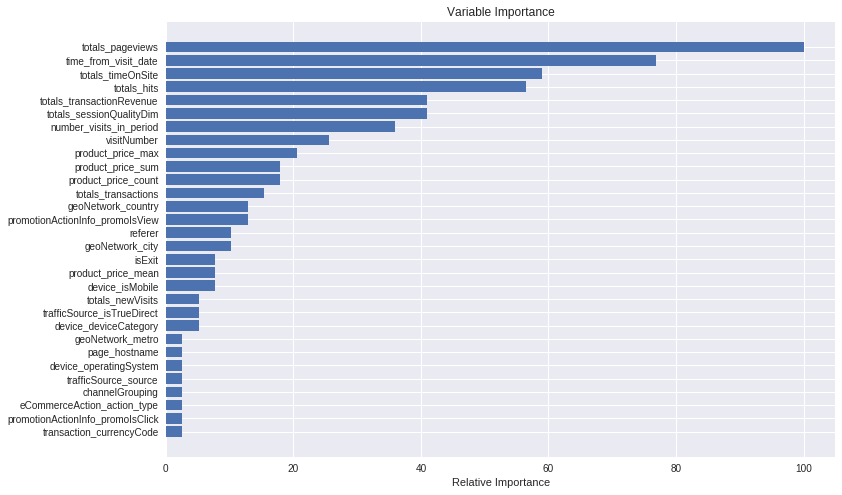

In [0]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## LGBM (https://www.kaggle.com/super13579/ga-v2-future-purchase-prediction)

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
params = {
    "max_bin": 512,
    "learning_rate": 0.02,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "num_leaves": 10,
    "min_data": 100,
    "boost_from_average": True
}

In [0]:
x_train = final_df[final_df.batch < 5][cat_features + numeric_features].copy()
x_val = final_df[final_df.batch == 5][cat_features + numeric_features].copy()
y_train = final_df[final_df.batch < 5]['purchase']
y_val = final_df[final_df.batch == 5]['purchase']

In [288]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000,  n_jobs = -1)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.0020911	valid_0's auc: 0.965353


LGBMClassifier(boost_from_average=True, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.02, max_bin=512, max_depth=-1,
        metric=['binary_logloss', 'auc'], min_child_samples=20,
        min_child_weight=0.001, min_data=100, min_split_gain=0.0,
        n_estimators=20000, n_jobs=-1, num_leaves=10, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
# model = lgb.LGBMClassifier(**params, n_estimators = 20000,  n_jobs = -1)
# model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.00209194	valid_0's auc: 0.969299


LGBMClassifier(boost_from_average=True, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.02, max_bin=512, max_depth=-1,
        metric=['binary_logloss', 'auc'], min_child_samples=20,
        min_child_weight=0.001, min_data=100, min_split_gain=0.0,
        n_estimators=20000, n_jobs=-1, num_leaves=10, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred_proba = model.predict_proba(x_val, num_iteration=model.best_iteration_)[:,1]

In [32]:
# y_pred = model.predict(x_val, num_iteration=model.best_iteration_) > 0.4
# print((y_pred == 1).sum())
# print(((y_pred == 1)& (y_val == 1)).sum())

11
1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [291]:
y_pred = y_pred_proba > 0.0001
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

85639
105


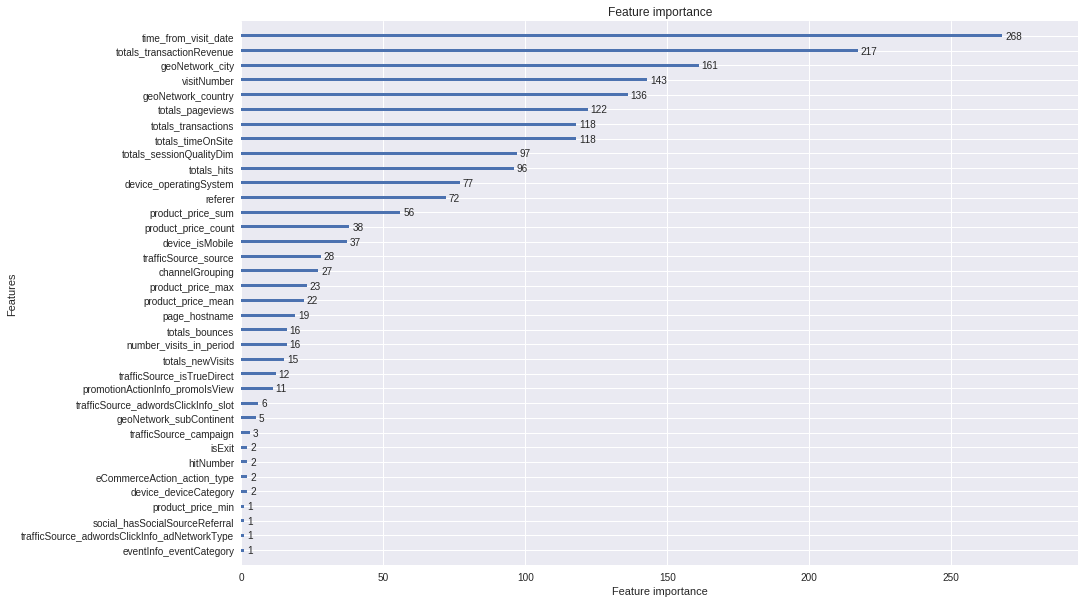

In [292]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

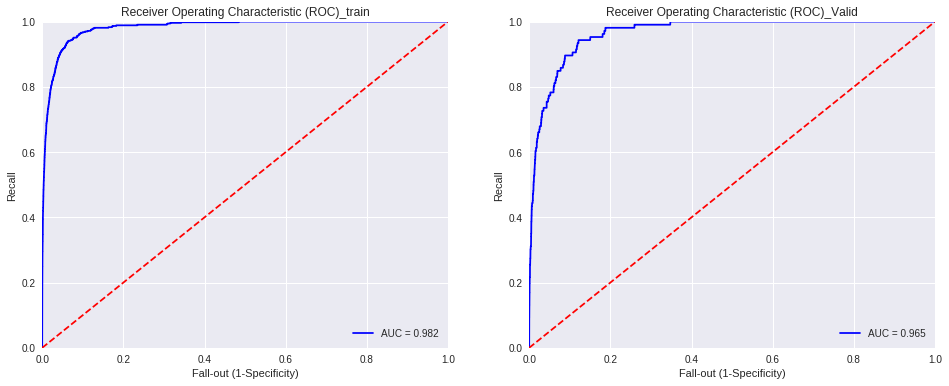

In [293]:
plt.figure(figsize=(16,6))
false_positive_rate, recall, thresholds = roc_curve(y_train, model.predict_proba(x_train, num_iteration=model.best_iteration_)[:,1])
roc_auc = auc(false_positive_rate, recall)
plt.subplot(121)
plt.title('Receiver Operating Characteristic (ROC)_train')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')

false_positive_rate, recall, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(false_positive_rate, recall)
plt.subplot(122)
plt.title('Receiver Operating Characteristic (ROC)_Valid')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

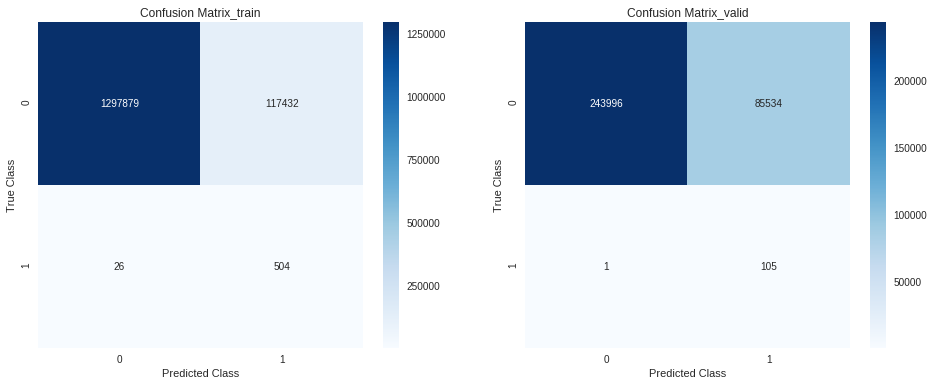

In [294]:
import seaborn as sns
#Print Confusion Matrix
plt.figure(figsize=(16,6))
cm1 = confusion_matrix(y_train, model.predict_proba(x_train, num_iteration=model.best_iteration_)[:,1] > 0.0005)
labels = ['0', '1']
plt.subplot(121)
sns.heatmap(cm1, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix_train')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

cm2 = confusion_matrix(y_val, y_pred_proba > 0.0001)
labels = ['0', '1']
plt.subplot(122)
sns.heatmap(cm2, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix_valid')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## XGB (https://www.kaggle.com/qnkhuat/base-model-v2-with-with-full-features)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost as xgb

In [0]:
x_train = final_df[final_df.batch < 5][cat_features + numeric_features].copy()
x_val = final_df[final_df.batch == 5][cat_features + numeric_features].copy()
y_train = final_df[final_df.batch < 5]['purchase']
y_val = final_df[final_df.batch == 5]['purchase']

In [0]:
def encode_data(verbose=False):
    global x_train_encoded,x_val_encoded
    x_train_encoded = x_train.copy()
    x_val_encoded = x_val.copy()
    for col in x_train.columns:
        if x_train_encoded[col].dtype.name == 'category' and col not in ['fullVisitorId','visitId','visitStartTime','date']:
            if verbose:
                print(col)
            lb = LabelEncoder()
            lb.fit( list(x_train_encoded[col].unique()) + list(x_val_encoded[col].unique()))
            x_train_encoded[col] = lb.transform(x_train_encoded[col])
            x_val_encoded[col] = lb.transform(x_val_encoded[col])

In [0]:
# x_train.dtypes

In [0]:
def run_xgb():
    params = {
        'objective':'binary:logistic',
        'eval_metric':'auc',
        'learning_rate':.01,
        'eta': 0.1, # Step size shrinkage used in update to prevents overfitting
#         'max_depth': 10, # V3 : 1.0471 on LB
        'max_depth':5,
        'subsample': 0.6, # sample of rows
        'colsample_bytree': 0.6, # sample of features
#         'alpha':0.001, 
        'lambda':1, # l2 regu
        'random_state': 42,
        'silent':True
        
    }
    xgb_train_data = xgb.DMatrix(x_train_encoded, y_train)
    xgb_val_data = xgb.DMatrix(x_val_encoded, y_val)
    
    model = xgb.train(params, xgb_train_data,
#           num_boost_round=1000, # V3 : 1.0471 on LB
          num_boost_round=200, # 1.0471 on LB
          evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
          early_stopping_rounds=10, 
          verbose_eval=20
         )
    return model

In [51]:
encode_data(verbose=True)

channelGrouping
contentGroup_contentGroup2
device_browser
device_deviceCategory
device_operatingSystem
eventInfo_eventAction
eventInfo_eventCategory
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_subContinent
page_hostname
referer
social_socialNetwork
trafficSource_adwordsClickInfo_adNetworkType
trafficSource_adwordsClickInfo_slot
trafficSource_medium
trafficSource_source


In [52]:
clf = run_xgb()

[0]	train-auc:0.519685	valid-auc:0.509368
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.688666	valid-auc:0.726869
[40]	train-auc:0.787156	valid-auc:0.808648
Stopping. Best iteration:
[43]	train-auc:0.787406	valid-auc:0.808824



In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,6)

Text(0.5,1,'Gain Feature important')

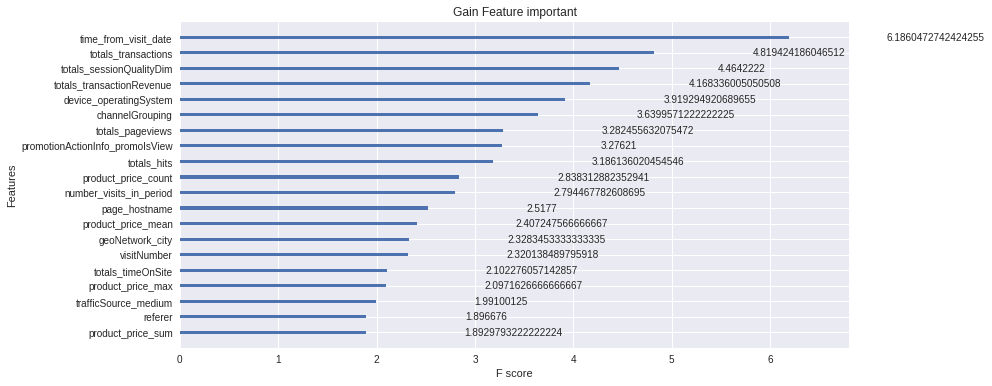

In [57]:
xgb.plot_importance(clf,importance_type='gain',max_num_features=20)
plt.title('Gain Feature important')

Text(0.5,1,'Cover Feature important')

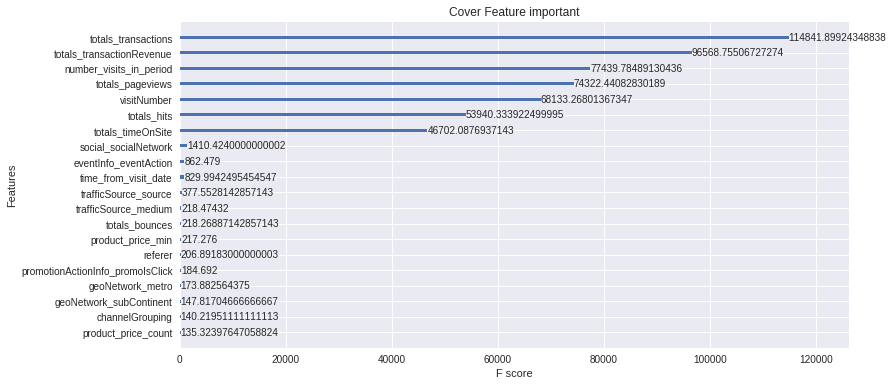

In [58]:
xgb.plot_importance(clf,importance_type='cover',max_num_features=20)
plt.title('Cover Feature important')

Text(0.5,1,'Weight Feature important')

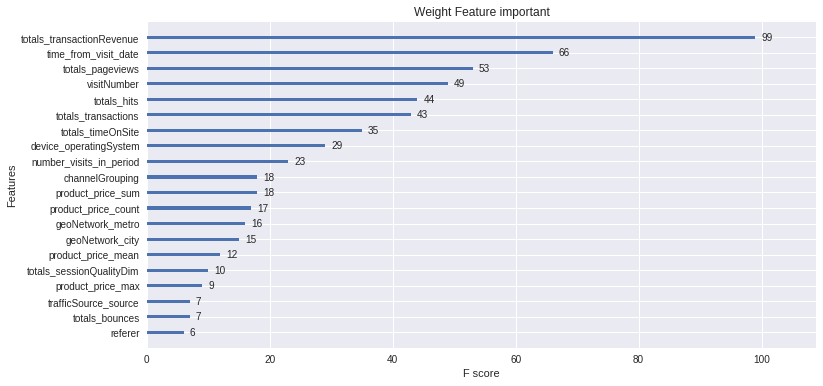

In [59]:
xgb.plot_importance(clf,importance_type='weight',max_num_features=20)
plt.title('Weight Feature important')

In [0]:
y_pred = y_pred_proba > 0.0005
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

In [0]:
y_pred_proba = clf.predict(xgb.DMatrix(x_val_encoded),ntree_limit=clf.best_ntree_limit)

In [85]:
y_pred = y_pred_proba > 0.32166513
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

24360
70


In [71]:
y_pred_proba.min()

0.3216612

## Random Forest

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, auc

In [0]:
def random_forest(x_train, x_val, y_train, y_val, columns='all', max_features='auto',
                  class_weight=None, min_samples_leaf=1, oob_score=False, n_estimators=10, printing=True, random_state=42):
    if columns == 'all':
        columns = [x for x in range(x_train.shape[1])]
    model = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators ,class_weight=class_weight, min_samples_leaf=min_samples_leaf, oob_score=oob_score, random_state=random_state, max_features=max_features)
    model.fit(x_train[:, columns], y_train)
    pred_train = model.predict(x_train[:, columns])
    train_metrics = calc_metrics(y_train, pred_train, data_type='Train', printing=printing)
    pred_val = model.predict(x_val[:, columns])
    val_metrics = calc_metrics(y_val, pred_val, data_type='Val', printing=printing)
    
    return (model, train_metrics, val_metrics)

def results_scaling_rf(x_train, x_val, y_train, y_val, x_test=None, y_test=None, #x_test_val, y_test_val, 
                       class_weight=None, printing=True, min_samples_leaf=1, oob_score=False, n_estimators=10, 
                       max_features='auto' ,random_state=42):

    model, train_metrics, val_metrics = random_forest(x_train, x_val, y_train, y_val, class_weight=class_weight, printing=printing,
                                                      min_samples_leaf=min_samples_leaf, oob_score=oob_score, n_estimators=n_estimators, 
                                                      random_state=random_state, max_features=max_features)
    
    if x_test is None or y_test is None:
        test_metrics = None
    else:
        test_metrics = calc_metrics(y_test, model.predict(x_test), data_type='Test')
   
    # test_val
#     pred = model.predict(x_test_val)

#     print("After {} weeks:".format(str(6)), pred.sum()/pred.shape[0], pred.sum())

#     test_val_metrics = calc_metrics(y_test_val, pred, data_type='Test-Val')
    
    return model, train_metrics, val_metrics, test_metrics#, test_val_metrics
  
  
def calc_metrics(y_true, y_pred, data_type='Result', labels=[0,1], pos_label=1, printing=True):
#     print (y_true, y_pred, data_type)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels, pos_label)
    recall = recall_score(y_true, y_pred, labels, pos_label)
    f1 = f1_score(y_true, y_pred, labels, pos_label)
    matrix = confusion_matrix(y_true, y_pred, labels)
    if printing:
        print("{}:".format(data_type))
        print(matrix)
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1: ", f1)
        print("")
        
    return (accuracy, precision, recall, f1, matrix)

In [0]:
def encode_data(verbose=False):
    global x_train_encoded,x_val_encoded
    x_train_encoded = x_train.copy()
    x_val_encoded = x_val.copy()
    for col in x_train.columns:
        if x_train_encoded[col].dtype.name == 'category' and col not in ['fullVisitorId','visitId','visitStartTime','date']:
            if verbose:
                print(col)
            lb = LabelEncoder()
            lb.fit( list(x_train_encoded[col].unique()) + list(x_val_encoded[col].unique()))
            x_train_encoded[col] = lb.transform(x_train_encoded[col])
            x_val_encoded[col] = lb.transform(x_val_encoded[col])

In [0]:
x_train = final_df[final_df.batch < 5][cat_features + numeric_features].copy()
x_val = final_df[final_df.batch == 5][cat_features + numeric_features].copy()
y_train = final_df[final_df.batch < 5]['purchase']
y_val = final_df[final_df.batch == 5]['purchase']

In [0]:
encode_data(verbose=True)

In [101]:
model_rf = random_forest(x_train_encoded.values, x_val_encoded.values, y_train, y_val, printing=True, min_samples_leaf=50, n_estimators=50, class_weight={0:1, 1:50})

Train:
[[1414084    1049]
 [    418     290]]
Accuracy:  0.9989638667053716
Precision:  0.21657953696788648
Recall:  0.4096045197740113
F1:  0.28334147532975085

Val:
[[329341    189]
 [    95     11]]
Accuracy:  0.9991384436165953
Precision:  0.055
Recall:  0.10377358490566038
F1:  0.0718954248366013



In [0]:
y_pred_proba = model_rf[0].predict_proba(x_val_encoded.values)

In [114]:
y_pred = y_pred_proba[:,1] > 0.025
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

30523
92


In [116]:
y_pred_proba.min(), y_pred_proba.max()

(0.0, 1.0)

## Prediction

In [0]:
from sklearn.metrics import precision_recall_curve

In [0]:
# final_df.fullVisitorId

In [0]:
# x_train = final_df[final_df.batch < 5][cat_features + numeric_features].copy()
x_val = final_df[final_df.batch == 5][cat_features + numeric_features].copy()
# y_train = final_df[final_df.batch < 5]['purchase']
y_val = final_df[final_df.batch == 5]['purchase']

In [0]:
previous_year_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum

In [33]:
# In $ term
(previous_year_transactions_sum[previous_year_transactions_sum > 0] / 1000000).describe()

count     106.000000
mean      158.695660
std       252.530707
min         5.400000
25%        25.715000
50%        52.770000
75%       139.962500
max      1311.430000
Name: totals_transactionRevenue_sum, dtype: float64

In [35]:
# In log term
np.log1p(previous_year_transactions_sum[previous_year_transactions_sum > 0]).describe()

count    106.000000
mean      18.004799
std        1.297342
min       15.501910
25%       17.061403
50%       17.781453
75%       18.756836
max       20.994384
Name: totals_transactionRevenue_sum, dtype: float64

In [0]:
all_periods_transactions_sum = final_df.totals_transactionRevenue_sum

In [41]:
# In $ term
(all_periods_transactions_sum[all_periods_transactions_sum > 0] / 1000000).describe()

count      814.000000
mean       332.708071
std       2469.743147
min          2.990000
25%         32.772500
50%         60.180000
75%        134.322500
max      50941.850000
Name: totals_transactionRevenue_sum, dtype: float64

In [42]:
# In log term
np.log1p(all_periods_transactions_sum[all_periods_transactions_sum > 0]).describe()

count    814.000000
mean      18.096364
std        1.320606
min       14.910784
25%       17.305100
50%       17.912846
75%       18.715754
max       24.653951
Name: totals_transactionRevenue_sum, dtype: float64

In [0]:
def get_score(true, pred):
  return np.sqrt(metrics.mean_squared_error(true.values, pred.values))

In [176]:
# Validation baseline all zero guess
get_score(np.log1p(previous_year_transactions_sum), previous_year_transactions_sum * 0)

0.32369635506448663

In [186]:
# Validation baseline (what is the constant prediction that will minimize the loss)
previous_year_data_prediction = pd.DataFrame(previous_year_transactions_sum)
best_score = 10
idx = 0
for i in range(100):
  previous_year_data_prediction["totals_transactionRevenue"] = i / 10000
  score = get_score(true=np.log1p(previous_year_transactions_sum), pred=previous_year_data_prediction["totals_transactionRevenue"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score)

58 0.323644572378678


The goal is to find set of rules that will reduce the RMSE bellow the baseline

### Version 1 - simple: select threshold manually to catch as many users that will not buy

In [74]:
y_pred.shape[0], final_test_df.shape

(329636, (296530, 46))

In [395]:
# y_pred_proba from secomd LGBM
y_pred = y_pred_proba > 0.0001
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

85639
105


In [296]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_modified_prediction = pd.DataFrame(val_transactions_sum)
val_modified_prediction[~y_pred] = 0
best_score = 10
idx = 0
for i in range(1000):
  val_modified_prediction.iloc[y_pred, 0] = i / 10000
  score = get_score(np.log1p(val_transactions_sum), val_modified_prediction["totals_transactionRevenue_sum"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score, idx/10000)

221 0.32350053443498095 0.0221


In [223]:
# val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
# val_modified_prediction = pd.DataFrame(val_transactions_sum)
# val_modified_prediction[~y_pred] = 0
# best_score = 10
# idx = 0
# for i in range(1000):
#   val_modified_prediction.iloc[y_pred, 0] = i / 10000
#   score = get_score(np.log1p(val_transactions_sum), val_modified_prediction["totals_transactionRevenue_sum"])
# #   print(i, score)
#   if score < best_score:
#     best_score = score
#     idx = i
# print(idx, best_score, idx/10000)

176 0.3235391492770354 0.0176


Test

In [0]:
x_test = final_test_df[cat_features + numeric_features].copy()

In [0]:
y_test_proba = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:,1]

In [0]:
y_test_pred = y_test_proba > 0.0001

In [305]:
y_test_pred.shape, y_test_pred.sum()

((296530,), 86152)

In [306]:
# The constant prediction should be adjusted acordingly to the differance between positive prediction in the val and test sets
# in this case there are 108598 positive users in the validation set and 102749 in the test set so the validation constant should be factored by 108598/102749 = 1.0569251282250922
val_to_test_factor = 108598/102749; val_to_test_factor

1.0569251282250922

In [307]:
constant_prediction = idx/10000 * val_to_test_factor
print (idx/10000, constant_prediction)

0.0221 0.02335804533377454


In [0]:
sub_df = pd.DataFrame({"fullVisitorId":final_test_df.reset_index().fullVisitorId});
sub_df["PredictedLogRevenue"] = 0
sub_df.iloc[y_test_pred, 1] = constant_prediction

In [0]:
sub_df.to_csv('lgbm_classification_and_023358_constant.csv', index=False)

In [310]:
sub_df.PredictedLogRevenue.sum()

2012.3423215953442

In [311]:
(sub_df.PredictedLogRevenue > 0).sum()

86152

In [314]:
86152 * 0.02335804533377454

2012.3423215953442

### Version 2 - advanced: select multiple thresholds

In [0]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

Text(0.5,1,'2-class Precision-Recall curve')

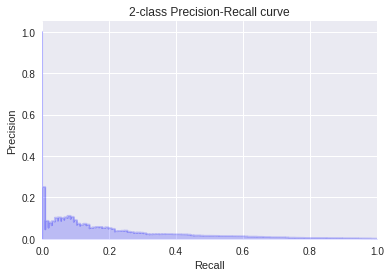

In [316]:
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

In [207]:
thresholds.shape

(48335,)

In [0]:
# attempt to select threshold using train and validate on validation
y_train_true = final_df[final_df.batch < 5].totals_transactionRevenue_sum
y_train_proba = model.predict_proba(x_train, num_iteration=model.best_iteration_)[:,1]

In [434]:
y_train_pred = y_train_proba > 0.0001
print((y_train == 1).sum())
print((y_train_pred == 1).sum())
print(((y_train_pred == 1)& (y_train == 1)).sum())

11080
77


In [435]:
y_pred = y_pred_proba > 0.0013
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

11080
77


In [437]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_modified_prediction = pd.DataFrame(val_transactions_sum)
val_modified_prediction[~y_pred] = 0
best_score = 10
idx = 0
for i in range(3000):
  val_modified_prediction.iloc[y_pred, 0] = i / 10000
  score = get_score(np.log1p(val_transactions_sum), val_modified_prediction["totals_transactionRevenue_sum"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score, idx/10000)

1253 0.3228804177135344 0.1253


### Version 3 - lgb regrassion

In [0]:
params_reg={'learning_rate': 0.02,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

In [0]:
y_train_reg = np.log1p(final_df[final_df.batch < 5]['totals_transactionRevenue_sum'])
y_val_reg = np.log1p(final_df[final_df.batch == 5]['totals_transactionRevenue_sum'])

In [352]:
reg = lgb.LGBMRegressor(**params_reg, n_estimators=3000)
reg.fit(x_train, y_train_reg, eval_set=[(x_val, y_val_reg)], early_stopping_rounds=100, verbose=500)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[142]	valid_0's rmse: 0.319661


LGBMRegressor(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.6, importance_type='split',
       learning_rate=0.02, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [0]:
reg_val_preds = reg.predict(x_val, num_iteration=reg.best_iteration_)

In [389]:
reg_val_preds.min(), reg_val_preds.max(), reg_val_preds.mean()

(-0.6178699613753548, 12.281593834555785, 0.00719219196960146)

In [356]:
np.sqrt(metrics.mean_squared_error(np.log1p(previous_year_transactions_sum).values, reg_val_preds))

0.319661136021031

In [357]:
reg_val_preds.sum()

2370.8053920915468

#### Option 1: using clasification threshod of 0.0001

In [396]:
y_pred = y_pred_proba > 0.0001
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

85639
105


In [0]:
clf_reg_val_pred = (reg_val_preds * y_pred).clip(0)

In [368]:
np.sqrt(metrics.mean_squared_error(np.log1p(previous_year_transactions_sum).values, clf_reg_val_pred))

0.3196150303701765

Test

In [0]:
x_test = final_test_df[cat_features + numeric_features].copy()

In [0]:
y_test_proba = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:,1]

In [0]:
y_test_pred = y_test_proba > 0.0001

In [0]:
reg_test_preds = reg.predict(x_test, num_iteration=reg.best_iteration_)

In [390]:
reg_test_preds.min(), reg_test_preds.max(), reg_test_preds.mean()

(-0.3961620893592233, 9.572880433029612, 0.00813822686449874)

In [0]:
clf_reg_test_pred = (reg_test_preds * y_test_pred).clip(0)

In [392]:
clf_reg_test_pred.min(), clf_reg_test_pred.max(), clf_reg_test_pred.mean()

(0.0, 9.572880433029612, 0.006607389361542576)

In [0]:
sub_df = pd.DataFrame({"fullVisitorId":final_test_df.reset_index().fullVisitorId});
sub_df["PredictedLogRevenue"] = clf_reg_test_pred

In [0]:
sub_df.to_csv('classification_with_regression_319615_on_validation.csv', index=False)

#### Option 2: using clasification threshod with best RMSE

In [430]:
best_th = 0
best_rmse = 100
for i in range(40):
  y_pred = y_pred_proba > i/10000
  y_val_pred_cr = (reg_val_preds * y_pred).clip(0)
  rmse = np.sqrt(metrics.mean_squared_error(np.log1p(previous_year_transactions_sum).values, y_val_pred_cr))
  print(i/10000, (y_pred == 1).sum(), ((y_pred == 1) & (y_val == 1)).sum(), rmse)
  if rmse < best_rmse:
    best_rmse = rmse
    best_th = i/10000
print(best_th, best_rmse)

0.0 329636 106 0.31962642624993853
0.0001 85639 105 0.3196150303701765
0.0002 55246 101 0.3195981177305097
0.0003 42038 100 0.31958211999467684
0.0004 33580 95 0.3195759631701392
0.0005 27081 91 0.319574198989226
0.0006 22729 88 0.319558524446634
0.0007 19735 83 0.31956405167781776
0.0008 17247 83 0.31953785641414845
0.0009 15360 80 0.3195399676429736
0.001 13984 78 0.31952261504256574
0.0011 12881 78 0.31950634574728753
0.0012 11918 78 0.3194829348637478
0.0013 11080 77 0.319477088365707
0.0014 10439 75 0.31955891041987583
0.0015 9885 74 0.31954981347238726
0.0016 9308 72 0.31958286186628504
0.0017 8790 72 0.31954097568747036
0.0018 8318 71 0.3196030431116576
0.0019 7867 70 0.3195940144320025
0.002 7543 70 0.3195841653424879
0.0021 7222 69 0.31956376933365266
0.0022 6962 68 0.31951874181653483
0.0023 6674 68 0.31951330527429633
0.0024 6422 67 0.31956174850985264
0.0025 6184 65 0.3197511034369848
0.0026 5996 65 0.31974558806762576
0.0027 5758 65 0.319738428639468
0.0028 5567 64 0.31973

In [416]:
y_pred = y_pred_proba > 0.0013
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

11080
77


In [0]:
y_val_pred_cr = (reg_val_preds * y_pred).clip(0)

In [427]:
np.sqrt(metrics.mean_squared_error(np.log1p(previous_year_transactions_sum).values, y_val_pred_cr))

0.319477088365707

Test

In [0]:
x_test = final_test_df[cat_features + numeric_features].copy()

In [0]:
y_test_proba = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:,1]

In [0]:
y_test_pred = y_test_proba > 0.0013

In [0]:
reg_test_preds = reg.predict(x_test, num_iteration=reg.best_iteration_)

In [422]:
reg_test_preds.min(), reg_test_preds.max(), reg_test_preds.mean()

(-0.3961620893592233, 9.572880433029612, 0.00813822686449874)

In [0]:
y_test_pred_cr = (reg_test_preds * y_test_pred).clip(0)

In [425]:
clf_reg_test_pred.min(), clf_reg_test_pred.max(), clf_reg_test_pred.mean()

(0.0, 9.572880433029612, 0.006607389361542576)

In [0]:
sub_df = pd.DataFrame({"fullVisitorId":final_test_df.reset_index().fullVisitorId});
sub_df["PredictedLogRevenue"] = clf_reg_test_pred

In [0]:
sub_df.to_csv('classification_with_regression_option2_319477_on_validation.csv', index=False)

### Version 4 - lgb regrassion with CV

In [0]:
params_reg={'learning_rate': 0.02,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

In [0]:
cv_val_preds = np.zeros(y_val.shape[0])
cv_test_preds = np.zeros(final_test_df.shape[0])

In [452]:
for batch in range(4):
  b_trn_x, b_trn_y = x_train = final_df[final_df.batch == batch+1][cat_features + numeric_features], np.log1p(final_df[final_df.batch == batch+1]['totals_transactionRevenue_sum'])
  reg = lgb.LGBMRegressor(**params, n_estimators=3000)
  reg.fit(b_trn_x, b_trn_y, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=500)
  
  cv_val_preds += reg.predict(x_val, num_iteration=reg.best_iteration_) / 4
  cv_test_preds += reg.predict(x_test, num_iteration=reg.best_iteration_) / 4

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.00244448	valid_0's auc: 0.966699
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.00210826	valid_0's auc: 0.954675
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.00232454	valid_0's auc: 0.956326
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.00231503	valid_0's auc: 0.939321


In [453]:
cv_val_preds.min(), cv_val_preds.max(), cv_val_preds.mean()

(0.00013396822785794764, 0.5294074952812553, 0.0005393330727655241)

In [455]:
np.sqrt(metrics.mean_squared_error(np.log1p(previous_year_transactions_sum).values, cv_val_preds))

0.32294721518223773

In [0]:
reg_val_preds.sum()

2370.8053920915468

In [0]:
319661136021031

### Other experiments

In [331]:
final_df[final_df.batch == 5].totals_transactionRevenue_sum.max()

1311430000.0

In [333]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_transactions_sum[val_transactions_sum > 0].mean()

158695660.3773585

In [334]:
1311430000.0 / 158695660.3773585

8.263805052271643

How would the resualt change if trained for average validation

In [336]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_transactions_sum.loc[val_transactions_sum > 0] = 7 * final_df[final_df.batch == 5].totals_transactionRevenue_sum.mean()
val_modified_prediction = pd.DataFrame(val_transactions_sum)
val_modified_prediction[~y_pred] = 0
best_score = 10
idx = 0
for i in range(1000):
  val_modified_prediction.iloc[y_pred, 0] = i / 10000
  score = get_score(np.log1p(val_transactions_sum), val_modified_prediction["totals_transactionRevenue_sum"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score, idx/10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157 0.22914482213262394 0.0157


In [256]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_transactions_sum[val_transactions_sum > 0] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:7626: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [257]:
val_transactions_sum

1415841    0.0
1415842    0.0
1415843    0.0
1415844    0.0
1415845    0.0
1415846    0.0
1415847    0.0
1415848    0.0
1415849    0.0
1415850    0.0
1415851    0.0
1415852    0.0
1415853    0.0
1415854    0.0
1415855    0.0
1415856    0.0
1415857    0.0
1415858    0.0
1415859    0.0
1415860    0.0
1415861    0.0
1415862    0.0
1415863    0.0
1415864    0.0
1415865    0.0
1415866    0.0
1415867    0.0
1415868    0.0
1415869    0.0
1415870    0.0
          ... 
1745447    0.0
1745448    0.0
1745449    0.0
1745450    0.0
1745451    0.0
1745452    0.0
1745453    0.0
1745454    0.0
1745455    0.0
1745456    0.0
1745457    0.0
1745458    0.0
1745459    0.0
1745460    0.0
1745461    0.0
1745462    0.0
1745463    0.0
1745464    0.0
1745465    0.0
1745466    0.0
1745467    0.0
1745468    0.0
1745469    0.0
1745470    0.0
1745471    0.0
1745472    0.0
1745473    0.0
1745474    0.0
1745475    0.0
1745476    0.0
Name: totals_transactionRevenue_sum, Length: 329636, dtype: float64

In [250]:
val_transactions_sum#.loc[val_transactions_sum.totals_transactionRevenue_sum > 0, 'totals_transactionRevenue_sum'] 

,index,totals_transactionRevenue_sum
0,1415841,0.0
1,1415842,0.0
2,1415843,0.0
3,1415844,0.0
4,1415845,0.0
5,1415846,0.0
6,1415847,0.0
7,1415848,0.0
8,1415849,0.0
9,1415850,0.0


In [0]:
tmp.loc[tmp[tmp.totals_transactionRevenue > 0].sample(n=4050, random_state=8).index, 'totals_transactionRevenue'] = 0

In [0]:
val_transactions_sum =  final_df[final_df.batch == 5].totals_transactionRevenue_sum
val_modified_prediction = pd.DataFrame(val_transactions_sum)

In [0]:
val_modified_prediction['pred'] = y_pred

In [0]:
val_modified_prediction[~y_pred] = 0

In [99]:
val_modified_prediction[val_modified_prediction.totals_transactionRevenue_sum > 0].describe()

,totals_transactionRevenue_sum
count,1.060000e+02
mean,1.586957e+08
std,2.525307e+08
min,5.400000e+06
25%,2.571500e+07
50%,5.277000e+07
75%,1.399625e+08
max,1.311430e+09


In [0]:
val_modified_prediction.loc[val_modified_prediction[(val_modified_prediction.totals_transactionRevenue_sum == 0) & (val_modified_prediction.pred)].sample(n=5849, random_state=8).index, 'pred'] = False

In [130]:
val_modified_prediction[val_modified_prediction.totals_transactionRevenue_sum > 0].describe()

,totals_transactionRevenue_sum
count,1.060000e+02
mean,1.586957e+08
std,2.525307e+08
min,5.400000e+06
25%,2.571500e+07
50%,5.277000e+07
75%,1.399625e+08
max,1.311430e+09


In [133]:
val_modified_prediction.head()

,totals_transactionRevenue_sum,pred
1415841,0.0,False
1415842,0.0,False
1415843,0.0,False
1415844,0.0,True
1415845,0.0,False


In [136]:
best_score = 10
idx = 0
for i in range(1000):
  val_modified_prediction.iloc[val_modified_prediction.pred.values, 0] = i / 10000
  score = get_score(previous_year_transactions_sum, val_modified_prediction["totals_transactionRevenue_sum"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score, idx/10000)

187 0.3235301987294363 0.0187


In [0]:
precision, recall, thresholds = precision_recall_curve()

In [0]:
# y_pred_proba from secomd LGBM
y_pred = y_pred_proba > 0.0005

In [0]:
y_pred = y_pred_proba > 0.0005
print((y_pred == 1).sum())
print(((y_pred == 1)& (y_val == 1)).sum())

In [140]:
final_df[final_df.batch == 5].totals_transactionRevenue_sum.sum() /100000

168217.4

In [127]:
test_df.columns

Index(['channelGrouping', 'contentGroup_contentGroup2', 'date',
       'device_browser', 'device_deviceCategory', 'device_isMobile',
       'device_operatingSystem', 'eCommerceAction_action_type',
       'eventInfo_eventAction', 'eventInfo_eventCategory', 'fullVisitorId',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_subContinent', 'hitNumber',
       'isEntrance', 'isExit', 'page_hostname', 'productPrice',
       'promotionActionInfo_promoIsClick', 'promotionActionInfo_promoIsView',
       'referer', 'social_hasSocialSourceReferral', 'social_socialNetwork',
       'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim', 'totals_timeOnSite',
       'totals_transactionRevenue', 'totals_transactions',
       'trafficSource_adwordsClickInfo_adNetworkType',
       'trafficSource_adwordsClickInfo_slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSou

In [0]:
# test_df before agggrigation for testing purposes
test_data_current_revenues = test_df.groupby('fullVisitorId')['totals_transactionRevenue'].sum()

In [0]:
test_data_zero_prediction = test_data_current_revenues.copy()
test_data_zero_prediction = test_data_zero_prediction * 0

In [138]:
get_score(test_data_current_revenues, test_data_zero_prediction)

2.113814148352661

In [158]:
# There 4156 users with purchase but we want to simulate what would have happend if only 106 would come back and purchase (the same as happend a yead ago)
(test_data_current_revenues > 0).sum()

4156

In [0]:
test_data_manipulated_revenues = test_df.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
test_data_manipulated_revenues.loc[test_data_manipulated_revenues[test_data_manipulated_revenues > 0].sample(n=4050, random_state=8).index] = 0

In [190]:
get_score(test_data_manipulated_revenues, test_data_zero_prediction)

0.3341405098983227

In [188]:
test_data_prediction = pd.DataFrame(test_data_zero_prediction)
best_score = 10
idx = 0
for i in range(100):
  test_data_prediction["totals_transactionRevenue"] = i / 10000
  score = get_score(test_data_manipulated_revenues, test_data_prediction["totals_transactionRevenue"])
#   print(i, score)
  if score < best_score:
    best_score = score
    idx = i
print(idx, best_score)

63 0.33412171432362753


## Some data analysis

In [0]:
# Target Variable Exploration:
train_df["totals_transactionRevenue"] = train_df["totals_transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

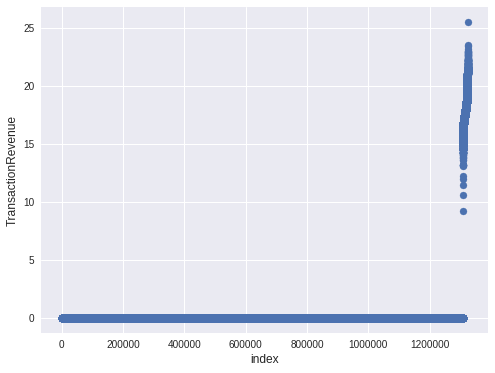

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals_transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [0]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  18514  and ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16141 and the ratio is :  0.012193574218307359


In [0]:
(gdf["totals_transactionRevenue"]>0).sum()

16141

In [0]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  1323730  out of rows :  1708337
Number of unique visitors in test set :  296530  out of rows :  401589
Number of common visitors in train and test set :  2759


In [0]:
# # Device Browser
# cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean']).rename(columns={'size':'count', 'count': 'count of non-zero revenue'}).sort_values(by="count", ascending=False).head(10)
# # ax = cnt_srs.plot.barh(rot=0, subplots=True)
# # ax[1].legend(loc=1) 
# cnt_srs.sort_values('count', ascending=True).plot.barh(subplots=True, figsize=(10,10), sharex=False)

In [0]:
# Device Category
# cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean']).rename(columns={'size':'count', 'count': 'count of non-zero revenue'}).sort_values(by="count", ascending=False).head(10)
# cnt_srs.sort_values('count', ascending=True).plot.barh(subplots=True, figsize=(10,10), sharex=False)

In [0]:
# cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean']).rename(columns={'size':'count', 'count': 'count of non-zero revenue'}).sort_values(by="count", ascending=False).head(10)
# cnt_srs.sort_values('count', ascending=True).plot.barh(subplots=True, figsize=(10,10), sharex=False)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
configure_plotly_browser_state()
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device_browser')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device_deviceCategory')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device_operatingSystem')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [0]:
configure_plotly_browser_state()
def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

cnt_srs = train_df.groupby('date')['totals_transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [0]:
configure_plotly_browser_state()
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [0]:
configure_plotly_browser_state()
# Continent
cnt_srs = train_df.groupby('geoNetwork_continent')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork_subContinent')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork_networkDomain')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [0]:
configure_plotly_browser_state()
# Continent
cnt_srs = train_df.groupby('trafficSource_source')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource_medium')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [0]:
configure_plotly_browser_state()
# Page views
cnt_srs = train_df.groupby('totals_pageviews')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals_hits')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [0]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'eCommerceAction_action_type', 'eventInfo_eventAction', 'page_hostname', 'appInfo_landingScreenName', 'promotionActionInfo_promoIsView', 'eventInfo_eventCategory', 'trafficSource_adwordsClickInfo_isVideoAd', 'appInfo_exitScreenName', 'contentGroup_contentGroup2', 'transaction_currencyCode', 'social_socialNetwork', 'page_pageTitle', 'transaction_affiliation', 'trafficSource_adwordsClickInfo_adNetworkType', 'social_hasSocialSourceReferral', 'trafficSource_adwordsClickInfo_slot', 'promotionActionInfo_promoIsClick'}


In [0]:
!pip install lightgbm

In [0]:
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

In [0]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [0]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", 
            "trafficSource.adContent", 
            "trafficSource.campaign", 
            "trafficSource.isTrueDirect", 
            "trafficSource.keyword", 
            "trafficSource.medium", 
#             "trafficSource.referralPath", 
            "trafficSource.source"]
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.source


In [0]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

## Old Training and Submission

In [0]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2018,2,28)]
val_df = train_df[train_df['date']>datetime.date(2018,2,28)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [0]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.51413
Early stopping, best iteration is:
[69]	valid_0's rmse: 1.51349


In [0]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.6107154420673264


In [0]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

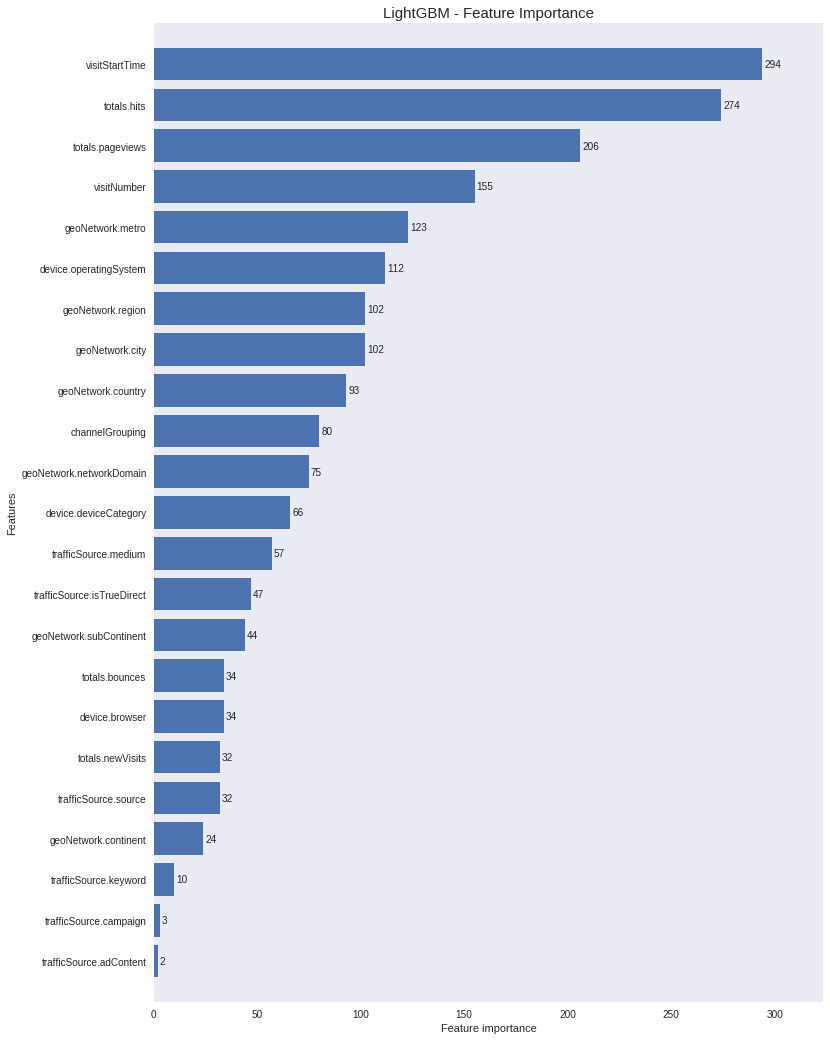

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()